<a href="https://colab.research.google.com/github/blid11/Group9/blob/Brett/G9_PartC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Changes made in this Colab notebook can be saved with Control/Command S and do not need to be pushed to Github. 
Also apparently SVM is a better model for classifying than the PCA/neural network I was trying below.

In [ ]:

# Import libaries needed
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

%cd gdrive/My Drive/G9A2/G9
 
#%cd gdrive/My Drive/G9A2
# I made a folder on my google drive that has the G9 Methylation data and the binfpy library
#this code automatically loads it in
# you can do the same with your google drive. 
# restart runtime if you experience errors!

Mounted at /content/gdrive
/content/gdrive/My Drive/G9A2/G9


# Data Preparation


In [ ]:
!ls

G9_liver_dna-meth.csv	mystery_dna-meth.csv
G9_liver_gene-expr.csv	mystery_gene-expr.csv


In [ ]:
# load the data 
liver_meth_dna = pd.read_csv('G9_liver_dna-meth.csv')
liver_gene_expr = pd.read_csv('G9_liver_gene-expr.csv')



In [ ]:
# view the data: 
liver_meth_dna.head(n = 2)
liver_gene_expr.shape

(421, 19938)

(421, 19547)


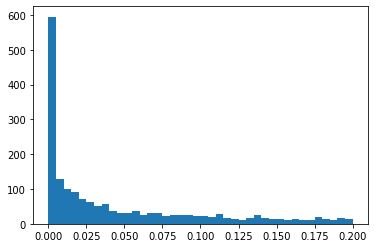

,Unnamed: 0,Label,X..100130426,X..100133144,X..100134869,X..10357,X..10431,X..155060,X..26823,X..280660,...,ZXDA.7789,ZXDB.158586,ZXDC.79364,ZYG11A.440590,ZYG11B.79699,ZYX.7791,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
0,TCGA.2V.A95S.01,Primary Tumor,-0.25593,-0.476165,0.134622,0.066483,-0.283215,0.263113,1.214289,-0.419556,...,-0.101024,-0.836486,-0.61156,-0.096129,-1.126977,-0.055131,0.760924,-0.132179,-0.011595,-0.962797
1,TCGA.2Y.A9GS.01,Primary Tumor,-0.25593,2.268472,-0.189274,-0.522460,-1.766629,0.114870,2.651003,-0.419556,...,1.535443,0.324199,0.75920,0.835624,0.233890,0.845728,0.390778,1.258929,0.418190,1.458766


In [ ]:
# standardizing and log transform data prior to PCA
# for each numeric value column in the dataframem, normalize 
# and log tranform the values


col_names_exp = liver_gene_expr.columns
col_names_meth = liver_meth_dna.columns

# 
#liver_gene_expr.replace([np.inf, -np.inf], 0, inplace=True)
#liver_meth_dna.replace([np.inf,-np.inf], 0, inplace=True)

expr_means = []

for column in liver_gene_expr[col_names_exp[2:]]:
  #liver_gene_expr[column] = liver_gene_expr[column].str.replace(regex ='[^0-9.]', value = "d") 
  #liver_gene_expr[column] = liver_gene_expr[column].str.replace(regex = 'd{10}]', value = "d") 
  col_mean = liver_gene_expr[column].mean()
  expr_means.append(col_mean)
  if col_mean > 0.025:
    liver_gene_expr[column] = liver_gene_expr[column].replace([np.inf, np.nan, -np.inf], col_mean)
  else: 
    liver_gene_expr = liver_gene_expr.drop(column, axis = 1)
  #liver_meth_dna[column] = liver_meth_dna[column].fillna(col_mean)

print(liver_gene_expr.shape)

plt.hist(expr_means, bins = 40, range = [0.0, 0.2])
plt.show()

col_names_exp = liver_gene_expr.columns
col_names_meth = liver_meth_dna.columns

for column in liver_meth_dna[col_names_meth[2:]]: 
  col_mean = liver_meth_dna[column].mean()
  liver_meth_dna[column] = liver_meth_dna[column].replace([np.inf, np.nan, -np.inf], col_mean)
  liver_meth_dna[column] = liver_meth_dna[column].fillna(col_mean)

#Normalize and log tranform data for both sets
for col_name in col_names_exp[2:]:
  col_data = pd.to_numeric(np.log2(liver_gene_expr[col_name].values + 1))
  col_mean = np.mean(col_data)
  col_std = np.std(col_data)
  new_data = (col_data - col_mean)/(col_std)
  liver_gene_expr[col_name] = new_data

for col_name in col_names_meth[2:]:
  col_data = pd.to_numeric(np.log2(liver_meth_dna[col_name].values + 1))
  col_mean = np.mean(col_data)
  col_std = np.std(col_data)
  new_data = (col_data - col_mean)/(col_std)
  liver_meth_dna[col_name] = new_data

liver_gene_expr.head(n= 2)


In [ ]:
liver_gene_expr.head(n = 2)

,Unnamed: 0,Label,X..100130426,X..100133144,X..100134869,X..10357,X..10431,X..136542,X..155060,X..26823,...,ZXDA.7789,ZXDB.158586,ZXDC.79364,ZYG11A.440590,ZYG11B.79699,ZYX.7791,ZZEF1.23140,ZZZ3.26009,psiTPTE22.387590,tAKR.389932
0,TCGA.2V.A95S.01,Primary Tumor,-0.25593,-0.476165,0.134622,0.066483,-0.283215,-0.067789,0.263113,1.214289,...,-0.101024,-0.836486,-0.61156,-0.096129,-1.126977,-0.055131,0.760924,-0.132179,-0.011595,-0.962797
1,TCGA.2Y.A9GS.01,Primary Tumor,-0.25593,2.268472,-0.189274,-0.522460,-1.766629,-0.067789,0.114870,2.651003,...,1.535443,0.324199,0.75920,0.835624,0.233890,0.845728,0.390778,1.258929,0.418190,1.458766


# Support Vector Machine

[[-0.25592957  2.26847154 -0.18927447 ...  1.2589292   0.41818955
   1.45876561]
 [-0.25592957 -1.5295894   0.33232946 ... -0.06286851  1.17940628
   0.44327843]
 [-0.25592957  0.65613272  0.47502188 ... -1.18261389 -0.36448635
  -1.40671968]]
False
[[-0.25592957 -0.47616495  0.13462249 ... -0.13217872 -0.01159508
  -0.96279728]
 [-0.25592957  2.26847154 -0.18927447 ...  1.2589292   0.41818955
   1.45876561]
 [-0.25592957 -1.5295894   0.33232946 ... -0.06286851  1.17940628
   0.44327843]
 ...
 [-0.25592957 -1.5295894   1.07851796 ...  0.19584219 -1.67430781
   0.67506188]
 [-0.25592957  0.90347699  1.2214136  ...  1.18408463 -0.29124152
   0.67193626]
 [-0.25592957 -1.5295894   1.00660325 ...  0.39696149  0.27911813
   0.61519723]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


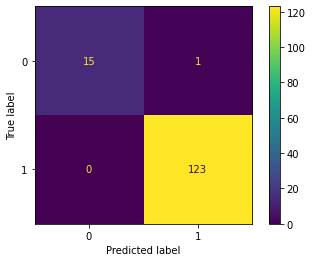

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.9928057553956835
Precision: 0.9928637734973311
Recall: 0.9928057553956835
Training set Accuracy: 0.9964539007092199
Training set Precision: 0.9965552178318136
Training set Recall: 0.9964539007092199


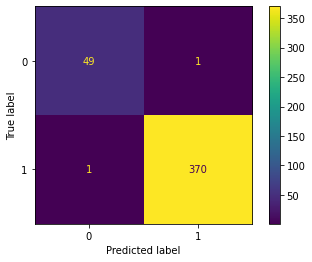

In [ ]:
## Encode the labels in 1 hot encoding
from sklearn import svm, metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.impute import SimpleImputer

# convert labels to 1 or 0 
bool_tum_expr = [1 if value == 'Primary Tumor' else 0 for value in liver_gene_expr['Label'].values]

exp_enc = LabelEncoder()
exp_enc.fit(bool_tum_expr)
encoded_Y = exp_enc.transform(bool_tum_expr)
# convert integers to dummy variables (i.e. one hot encoded)

#sklearn's SimpleImputer can replace the missing values in a column
#with the columns mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
exp_data = imp.fit_transform(liver_gene_expr[col_names_exp[2:]])
print(exp_data[1:4,:])

print(np.any(np.isnan(exp_data)))
print(exp_data)
X_train, X_test, y_train, y_test = train_test_split(exp_data, bool_tum_expr, test_size=0.33, random_state=42)

# Run a SVM
# https://scikit-learn.org/stable/modules/svm.html
clf_tumours = svm.SVC(kernel='rbf')
clf_tumours.fit(X_train, y_train)
plot_confusion_matrix(clf_tumours, X_test, y_test)  
plt.show()
plot_confusion_matrix(clf_tumours, exp_data, bool_tum_expr) 

y_pred = clf_tumours.predict(X_test)
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# Model Precision: what is the percentage of positive class predictions that actually belong to the positive class?
print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))
# Model Recall: what is the percentage of positive class predictions made out of all positive examples in the dataset.
print("Recall:",metrics.recall_score(y_test, y_pred, average='weighted'))

y_pred_train = clf_tumours.predict(X_train)
# Model Accuracy: how often is the classifier correct?
print("Training set Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
# Model Precision: what is the percentage of positive class predictions that actually belong to the positive class?
print("Training set Precision:",metrics.precision_score(y_train, y_pred_train, average='weighted'))
# Model Recall: what is the percentage of positive class predictions made out of all positive examples in the dataset.
print("Training set Recall:",metrics.recall_score(y_train, y_pred_train, average='weighted'))

In [ ]:

mys_meth_dna = pd.read_csv('mystery_dna-meth.csv')
mys_gene_expr = pd.read_csv('mystery_gene-expr.csv')
col_names_exp_mys = mys_gene_expr.columns
col_names_meth_mys = mys_meth_dna.columns

NameError: ignored

# PCA

Alternatively, one could perform PCA on the data to determine which features are most important to reduce dimensionality prior to training an SVM or a neural network.

True
(20531, 20)


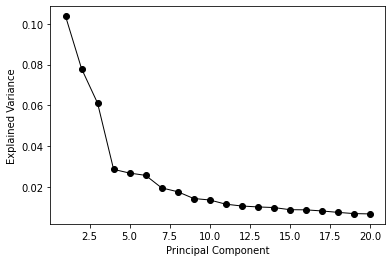

[0.10370629 0.07798418 0.06108182 0.02861618 0.02679588 0.02567671
 0.0195272  0.01766106 0.01432843 0.01360874 0.01155351 0.010653
 0.01019934 0.00990339 0.00885247 0.00877028 0.00822711 0.00753337
 0.00693344 0.00677224]


In [ ]:
# Using PCA
# turn into PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
print(liver_gene_expr.isnull().values.any())

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
exp_data = imp.fit_transform(liver_gene_expr[col_names_exp[2:]].T)

#scale the data
scaler = StandardScaler()
scaler.fit(exp_data)
exp_data=scaler.transform(exp_data) 

#print(liver_gene_expr.apply(pd.isna).all())

#try 10 components or more
exp_pca = PCA(n_components=20)
exp_pc_data = exp_pca.fit_transform(exp_data)

print(exp_pc_data.shape)

PC_values = np.arange(exp_pca.n_components_) + 1
plt.plot(PC_values, exp_pca.explained_variance_ratio_, 'o-', linewidth=1, color='black')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

print(exp_pca.explained_variance_ratio_)

# 


# TensorBoard for Model Evaluation

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# %reload_ext tensorboard

%tensorboard --logdir /dir/

# or use %tensorboard --logdir /dir/

# Xinwei' work


I have been created the 4 model - random forest, logistic regression, SVM, and Multilayer perception.
number of features depend on the cumulatife explained variance ratio (generally chossing number which >= 90%) 

In [ ]:
# Import libaries needed
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.preprocessing import scale # scale and canter data
from sklearn.svm import SVC # make a svm for classification
from sklearn.model_selection import GridSearchCV # do cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draw confutionm matrix
from sklearn.decomposition import PCA # perform PAC to plot the data
import matplotlib.pyplot as plt
from matplotlib import style 
import numpy as np
import seaborn as sns


In [ ]:
import pandas as pd
dna = pd.read_csv("/mystery_dna-meth.csv") # data1
gene = pd.read_csv("/mystery_gene-expr.csv") #data2
#dna = pd.read_csv("G9_liver_dna-meth.csv") # G9-data1
#gene = pd.read_csv("G9_liver_gene-expr.csv") # G9-data2

# this is mystery data, if you want to run G9 data just change the road
dna.head()

,Unnamed: 0,Label,cg00001583,cg00001747,cg00002719,cg00011616,cg00013655,cg00025347,cg00034076,cg00036011,...,cg27527798,cg27538352,cg27539986,cg27546977,cg27553926,cg27583037,cg27592331,cg27623451,cg27633287,cg27649037
0,TCGA.C8.A274.01,Primary Tumor,0.776662,0.809844,0.891880,0.328564,0.849209,0.235096,0.714533,0.048083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA.E2.A572.01,Primary Tumor,0.669769,0.029292,0.761326,0.188135,0.830146,0.308065,0.742329,0.413321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TCGA.AO.A0JA.01,Primary Tumor,0.505964,0.525509,0.806467,0.940331,0.711453,0.328805,0.155193,0.031138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TCGA.E2.A1BD.01,Primary Tumor,0.814448,0.814974,0.902881,0.069385,0.927201,0.225843,0.794465,0.766701,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TCGA.AC.A5EH.01,Primary Tumor,0.418687,0.031154,0.449726,0.160170,0.617900,0.605715,0.076246,0.067412,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# check the data
dna.info(),gene.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Columns: 18093 entries, Unnamed: 0 to cg27649037
dtypes: float64(18091), object(2)
memory usage: 52.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Columns: 20823 entries, Unnamed: 0 to ZFP91.CNTF.386607
dtypes: float64(20821), object(2)
memory usage: 60.4+ MB


(None, None)

In [ ]:
# find all features
features1 = list(dna.columns[2:])
features2 = list(gene.columns[2:])
print(f"dna- features count: {len(features1)}")
print(f"gene- features count: {len(features2)}")
target = 'Label'
print(f"dna - label count: {dna[target].value_counts()}")
print(f"gene - label count: {gene[target].value_counts()}")

dna- features count: 18091
gene- features count: 20821
dna - label count: Primary Tumor          190
Solid Tissue Normal    190
Name: Label, dtype: int64
gene - label count: Primary Tumor          190
Solid Tissue Normal    190
Name: Label, dtype: int64


2 method to deal with data shown 'NaN'

In [ ]:
# option 1:  Change all NaN value into 0
dna.isnull().sum(axis=1)
dna = dna.fillna(0)
gene = gene.fillna(0)

dna.head()

,Unnamed: 0,Label,cg00001583,cg00001747,cg00002719,cg00011616,cg00013655,cg00025347,cg00034076,cg00036011,...,cg27527798,cg27538352,cg27539986,cg27546977,cg27553926,cg27583037,cg27592331,cg27623451,cg27633287,cg27649037
0,TCGA.C8.A274.01,Primary Tumor,0.776662,0.809844,0.891880,0.328564,0.849209,0.235096,0.714533,0.048083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TCGA.E2.A572.01,Primary Tumor,0.669769,0.029292,0.761326,0.188135,0.830146,0.308065,0.742329,0.413321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TCGA.AO.A0JA.01,Primary Tumor,0.505964,0.525509,0.806467,0.940331,0.711453,0.328805,0.155193,0.031138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TCGA.E2.A1BD.01,Primary Tumor,0.814448,0.814974,0.902881,0.069385,0.927201,0.225843,0.794465,0.766701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TCGA.AC.A5EH.01,Primary Tumor,0.418687,0.031154,0.449726,0.160170,0.617900,0.605715,0.076246,0.067412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# option 2: Lagrange function
# if value with NaN - Larange method
from scipy.interpolate import lagrange

def poly_larange(s, n, k=5):
    y = s[list(range(n-k, n)) + list(range(n+1, n+1+k))]
    y = y[y.notnull()]
    return lagrange(y.index, list(y))(n)

dna = dna.copy()
for i in dna.columns:
    for j in range(len(dna)):
        if(dna[i].isnull())[j]:
            dna.loc[j,i] = poly_larange(dna[i], j)
dna

gene = gene.copy()
for i in gene.columns:
    for j in range(len(gene)):
        if(gene[i].isnull())[j]:
            gene.loc[j,i] = poly_larange(gene[i], j)
gene

### Normalization

In [ ]:
#Normalization
X1 = dna[features1]
y1 = dna[target]

X2 = gene[features2]
y2 = gene[target]

# for data 1
# apply minmaxscaler to X
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
X1 = MinMaxScaler().fit_transform(X1)
# apply label encoder to y
lbe1 = LabelEncoder()
y1 = lbe1.fit_transform(y1)

# for data 2
# apply minmaxscaler to X
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
X2 = MinMaxScaler().fit_transform(X2)
# apply label encoder to y
lbe2 = LabelEncoder()
y2 = lbe2.fit_transform(y2)

## PCA

DNA


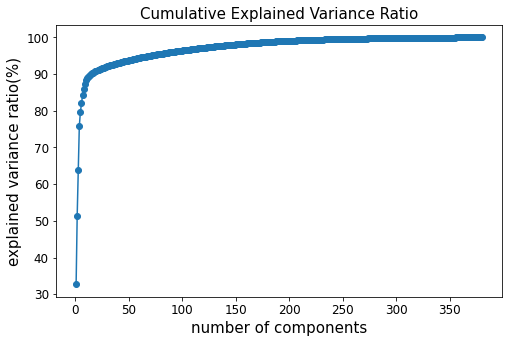

Decomposition： (380, 18091) --> (380, 20)
Gene


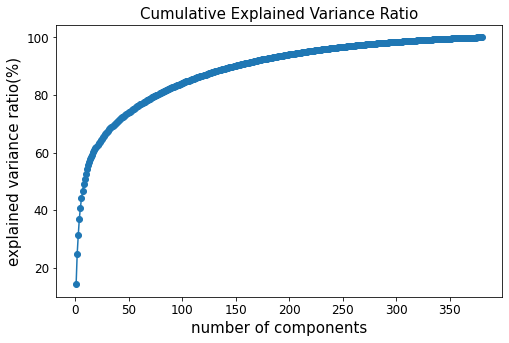

Decomposition： (380, 20821) --> (380, 150)


In [ ]:
# Feature number selelction / PCA
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
# PCA analysis, extract main components
def PCA_n(X_scaled):
    estimator_pca = PCA(n_components=None)
    estimator_pca.fit(X_scaled)
    evr = estimator_pca.explained_variance_ratio_ 
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(1, len(evr) + 1), np.cumsum(evr*100), "-o")
    plt.title("Cumulative Explained Variance Ratio", fontsize=15)
    plt.xlabel("number of components",fontsize=15)
    plt.ylabel("explained variance ratio(%)",fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

def pcaX(X_scaled,n):#data dimension reduction
    pca = PCA(n_components=n)
    pca_X = pca.fit_transform(X_scaled)
    print('Decomposition：',X_scaled.shape,'-->',pca_X.shape)
    return pd.DataFrame(pca_X)

# Because the dimension of data is too high and there are too many features, 
# PCA method is used to extract features.

# High-dimensional data is reduced to low-dimensional data, 
# and the main information is extracted for training.
print("DNA")
PCA_n(X1)
pca_X1 = pcaX(X1,20) # feature selection
print("Gene")
PCA_n(X2)
pca_X2 = pcaX(X2,150) # feature selection




```
# This is formatted as code
```

# Model - Random Forest, Logistic regression, SVM, Multilayer Perceptron

==============DataSet1 - Mestery_dna-meth.csv==============
【RF_cls_model】
training time: 0.1916s
finished RandomForestClassifier model training...
evaluation:
{'accuracy': 0.9736842105263158, 'precision': 0.975, 'recall': 0.9736842105263157, 'f1-score': 0.9736659736659736}


【LR_cls_model】
training time: 0.0488s
finished LogisticRegression model training...
evaluation:
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0}


【SVM_cls_model】
training time: 0.0167s
finished SVC model training...
evaluation:
{'accuracy': 0.9868421052631579, 'precision': 0.9871794871794872, 'recall': 0.986842105263158, 'f1-score': 0.9868398268398267}


【MLP_cls_model】
training time: 0.6456s
finished MLPClassifier model training...
evaluation:
{'accuracy': 0.9868421052631579, 'precision': 0.9871794871794872, 'recall': 0.986842105263158, 'f1-score': 0.9868398268398267}




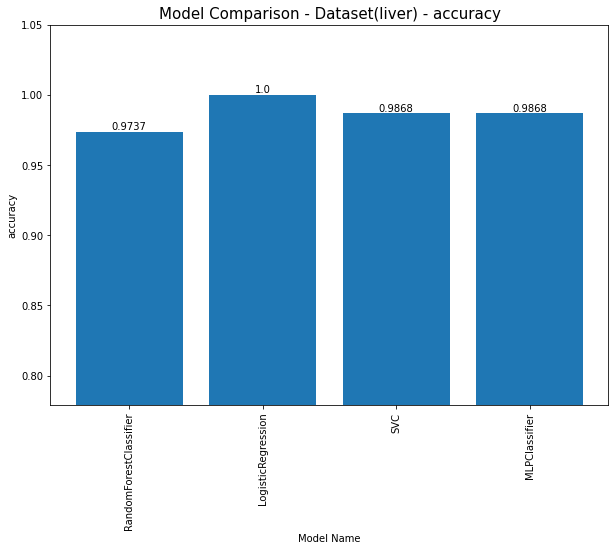


==============DataSet2 - Mystery_gene-expr.csv==============
【RF_cls_model】
training time: 0.0735s
finished RandomForestClassifier model training...
evaluation:
{'accuracy': 0.881578947368421, 'precision': 0.8949820788530466, 'recall': 0.881578947368421, 'f1-score': 0.8805657412257726}


【LR_cls_model】
training time: 0.1138s
finished LogisticRegression model training...
evaluation:
{'accuracy': 0.9868421052631579, 'precision': 0.9871794871794872, 'recall': 0.986842105263158, 'f1-score': 0.9868398268398267}


【SVM_cls_model】
training time: 0.1034s
finished SVC model training...
evaluation:
{'accuracy': 0.9736842105263158, 'precision': 0.975, 'recall': 0.9736842105263157, 'f1-score': 0.9736659736659736}


【MLP_cls_model】
training time: 1.1493s
finished MLPClassifier model training...
evaluation:
{'accuracy': 0.9342105263157895, 'precision': 0.9345114345114345, 'recall': 0.9342105263157894, 'f1-score': 0.9341991341991341}




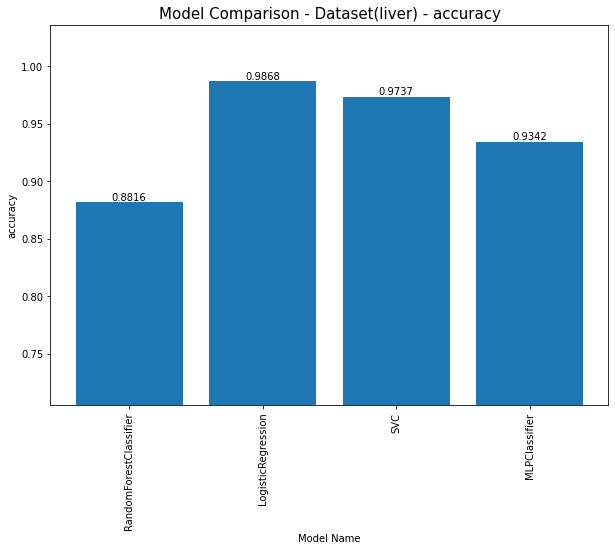

In [ ]:
## test 70% train 30%
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(pca_X1, y1,
                                                    test_size=0.20, random_state=30)

X_train2, X_test2, y_train2, y_test2 = train_test_split(pca_X2, y2,
                                                    test_size=0.20, random_state=30)
import numpy as np
import time
# Define model performance evaluation methods
def evaluation(y_test,y_pred,model_type = 'regression'):
	"""
	enter real - y_test和prediction - y_pred，evaluate model
	model_type = regression #evaluate regression model
	model_type = classification  # evaluate classification model
	"""
	metrics = {}
	# if classification model
	if model_type == 'classification':
		from sklearn.metrics import classification_report
		from sklearn.metrics import accuracy_score   
		from sklearn.metrics import precision_score	
		from sklearn.metrics import recall_score	  #sensitivity
		from sklearn.metrics import f1_score		
		# metrics['cls_report'] = classification_report(y_test, y_pred)
		metrics['accuracy'] = accuracy_score(y_test,y_pred)
		metrics['precision'] =  precision_score(y_test,y_pred,average='macro')
		metrics['recall'] = recall_score(y_test,y_pred,average='macro')
		metrics['f1-score'] = f1_score(y_test,y_pred,average='macro')
		
	# if regression model
	elif model_type== 'regression':
		from sklearn.metrics import mean_squared_error
		from sklearn.metrics import mean_absolute_error
		from sklearn.metrics import r2_score
		metrics['MSE'] = mean_squared_error(y_test,y_pred)
		metrics['SCORE'] = mean_squared_error(y_test,y_pred) ** 0.5
		metrics['MAE'] = mean_absolute_error(y_test,y_pred)
		metrics['R2'] = r2_score(y_test,y_pred)
	else:
		raise Exception('model_type should be classification or regression!')
	return metrics

## Random Forest
def RF_cls_model(X_train,y_train,X_test,y_test):
	time_start = time.time()
	from sklearn.ensemble import RandomForestClassifier
	RF = RandomForestClassifier(n_estimators=10)
	RF.fit(X_train,y_train)
	time_end = time.time()
	print(f"training time: {(time_end-time_start):.4f}s")
	# evaluate model 
	# test set prediction
	y_pred_RF = RF.predict(X_test)
	# performance evaluation
	metrics= evaluation(y_test,y_pred_RF,model_type='classification')
	return RF,metrics

## Logistic Regression
def LR_cls_model(X_train,y_train,X_test,y_test):
	time_start = time.time()
	from sklearn.linear_model import LogisticRegression
	LR = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
	# train model
	LR.fit(X_train, y_train)
	time_end = time.time()
	print(f"training time: {(time_end-time_start):.4f}s")
	# predict test set result
	y_pred_LR = LR.predict(X_test)
	metrics  = evaluation(y_test,y_pred_LR,model_type='classification')
	return LR,metrics

# SVM 
def SVM_cls_model(X_train,y_train,X_test,y_test):
	time_start = time.time()
	from sklearn.svm import SVC
	svc = SVC(C=1.0,kernel='rbf',probability=True)
	# train model
	svc.fit(X_train, y_train)
	time_end = time.time()
	print(f"training time: {(time_end-time_start):.4f}s")
	# predict test set result
	y_pred_SVC = svc.predict(X_test)
	metrics  = evaluation(y_test,y_pred_SVC,model_type='classification')
	return svc,metrics

# sklearn bp - Multilayer perceptron (MLP)
def MLP_cls_model(X_train,y_train,X_test,y_test):
	time_start = time.time()
	from sklearn.neural_network import MLPClassifier
	MLP = MLPClassifier(random_state=1, max_iter=300)
	# trian model
	MLP.fit(X_train, y_train)
	time_end = time.time()
	print(f"training time: {(time_end-time_start):.4f}s")
	# predict test set result
	y_pred_MLP = MLP.predict(X_test)
	metrics  = evaluation(y_test,y_pred_MLP,model_type='classification')
	return MLP,metrics
import matplotlib.pyplot as plt
def plot_metric(metric_dic,metric = 'SCORE',dataset_name = 'None'):
	"""
	metric_dic looks like: {'model_name':{'metric_name': value}}
	"""
	# plot and comparison of indicators for each model
	x = []
	y = []
	# xtraction data
	for model_name in metric_dic.keys():
		x.append(model_name)
		y.append(metric_dic.get(model_name).get(metric))
	plt.figure(figsize=(10,7))
	# histogram
	plt.bar(x,y)
	for i,j in zip(range(len(x)),y):
		plt.text(i,j,'{:.4}'.format(j),va='bottom',ha='center')
	# title, name of axis
	plt.title(f"Model Comparison - Dataset({dataset_name}) - {metric}",fontsize=15)
	plt.xlabel("Model Name")
	plt.ylabel(metric)
	plt.xticks(rotation=90)
	plt.ylim(np.min(y)*0.8,np.max(y)*1.05)
	# save pic
	plt.savefig(f"Model Comparison - Dataset({dataset_name}) - {metric}.jpg",dpi=200)
	plt.show()

######### Dataset 1
# Select the classification model for training
cls_models = [RF_cls_model,LR_cls_model,SVM_cls_model,MLP_cls_model]
# classification model
model_type = 'classification'
eval_dic1 = {}
models = []
#  data set1
print("==============DataSet1 - Mestery_dna-meth.csv==============")
for model in cls_models:
	print(f"【{model.__name__}】")
	model,metrics = model(X_train1,y_train1,X_test1,y_test1)
	models.append(model)
	# evaluation result 
	eval_dic1[type(model).__name__] = metrics.copy()
	print(f"finished {type(model).__name__} model training...")
	print("evaluation:")
	print(metrics)
	print('\n')
plot_metric(eval_dic1,metric='accuracy',dataset_name='liver')

######### Dataset 2
print("\n==============DataSet2 - Mystery_gene-expr.csv==============")
model_type = 'classification'
eval_dic2 = {}
models = []
cls_models = [RF_cls_model,LR_cls_model,SVM_cls_model,MLP_cls_model]
# data set2
for model in cls_models:
	print(f"【{model.__name__}】")
	model,metrics = model(X_train2,y_train2,X_test2,y_test2)
	models.append(model)
	# result 
	eval_dic2[type(model).__name__] = metrics.copy()
	print(f"finished {type(model).__name__} model training...")
	print("evaluation:")
	print(metrics)
	print('\n')

plot_metric(eval_dic2,metric='accuracy',dataset_name='liver')

# Group Model

In [ ]:
# load the data 
liver_methyl = pd.read_csv('G9_liver_dna-meth.csv')
liver_gene = pd.read_csv('G9_liver_gene-expr.csv')
mys_methyl = pd.read_csv("/mystery_dna-meth.csv")
mys_gene = pd.read_csv("/mystery_gene-expr.csv") 


## 1. Data Preparation



### 1.1 Data Cleaning
- Separate Data and Labels
- Rows without labels should be removed. 
- Empty columns should (zeros and Na's) should be removed. 

#### Separate Data and Labels

In [ ]:
# For liver datasets
liver_methyl_data = liver_methyl
liver_methyl_labels = 
liver_gene_data =
liver_gene_labels = 

# For mystery datasets
mys_methyl = pd.read_csv("/mystery_dna-meth.csv")
mys_gene = pd.read_csv("/mystery_gene-expr.csv") 

### Imputing Data Method 1: Lagrange

In [ ]:
from scipy.interpolate import lagrange

def poly_larange(s, n, k=5):
    y = s[list(range(n-k, n)) + list(range(n+1, n+1+k))]
    y = y[y.notnull()]
    return lagrange(y.index, list(y))(n)

liver_gene = liver_gene.copy()
for i in liver_gene.columns:
    for j in range(len(liver_gene)):
        if(liver_gene[i].isnull())[j]:
            liver_gene.loc[j,i] = poly_larange(liver_gene[i], j)

liver_methyl = liver_methyl.copy()
for i in liver_methyl.columns:
    for j in range(len(liver_methyl)):
        if(liver_methyl[i].isnull())[j]:
            liver_methyl.loc[j,i] = poly_larange(liver_methyl[i], j)


### Imputing Data Method 2: Column Means

In [ ]:
liver_gene.head(n=2)

In [ ]:
liver_methyl.head(n=2)

#### Removing Genes with Low Expression

In [ ]:
expr_means = []

for column in liver_gene_expr[col_names_exp[2:]]:
  col_mean = liver_gene_expr[column].mean()
  expr_means.append(col_mean)
  if col_mean > 0.025:
    liver_gene_expr[column] = liver_gene_expr[column].replace([np.inf, np.nan, -np.inf], col_mean)
  else: 
    liver_gene_expr = liver_gene_expr.drop(column, axis = 1)

print(liver_gene_expr.shape)

plt.hist(expr_means, bins = 40, range = [0.0, 0.2])
plt.show()

### Normalization


## Feature Selection: 
-Want to use only a subset of genes/methylation tags
for each model